# <신용카드 고객 분석 및 이탈고객 예측>

고객이 자사 신용카드를 더이상 사용하지 않고 이탈해버리는 것은 은행에서는 큰 비즈니스적 문제이다. 따라서 어떤 요소들이 고객이탈과 관련있는지 파악하고, 이탈을 방지할 수 있는 방안들을 마련할 필요가 있다.

이를 위해 10127개의 고객 데이터를 분석한 뒤, Random Forest와 XGBoost 두 모델을 활용해 어떤 요소들이 고객의 이탈에 가장 관련이 있는지 파악한다.

[가설] <br>
소득이 적을 수록, 카드 등급이 낮을 수록, 카드사용 금액이 적을 수록 이탈 가능성이 높을 것이다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import warnings
warnings.filterwarnings(action = 'ignore')

# 1. 데이터 확인

In [2]:
df = pd.read_csv('./data/BankChurners/BankChurners.csv')

In [3]:
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


### 컬럼 정보

- CLIENTNUM ------------------ 클라이언트 고유번호
- <strong>Attrition_Flag ------------------ 계정이 존재/폐쇄 여부 -> 타겟값</strong>
- Customer_Age --------------- 고객의 연령
- Gender -------------------------- M = 남성, F = 여성
- Dependent_count ------------ 부양 가족 수 
- Education_Level ------------- 계좌 소유자의 최종 학력             
- Marital_Status ---------------- 기혼, 미혼, 이혼, 알 수 없음               
- Income_Category ------------ 계정 소유자의 연간 소득 범주
- Card_Category --------------- 카드 유형 (블루, 실버, 골드, 플래티넘)         
- Months_on_book ------------- 은행과의 거래 기간(월)
- Total_Relationship_Count -- 고객이 보유한 카드 수
- Months_Inactive_12_mon -- 지난 12 개월 동안 비활성 상태인 개월 수
- Contacts_Count_12_mon -- 지난 12 개월 동안의 연락처 수      
- Credit_Limit -------------------- 신용 카드 신용 한도
- Total_Revolving_Bal --------- 신용 카드의 총 잔액         
- Avg_Open_To_Buy ---------- 신용 한도 구매 가능 금액 (지난 12 개월 평균)
- Total_Amt_Chng_Q4_Q1 -- 거래 금액의 변동 (Q1 대비 Q4)
- Total_Trans_Amt ------------- 총 거래 금액 (지난 12 개월)
- Total_Trans_Ct --------------- 총 거래 수 (지난 12 개월)    
- Total_Ct_Chng_Q4_Q1 ---- 거래 건수 변경 (Q1 대비 Q4)   
- Avg_Utilization_Ratio ------- 평균 카드 사용률

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

데이터는 10127개의 행과 21개의 열로 이루어져 있다.

In [5]:
# NaN 값이 있는지 확인
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# 2. EDA

In [6]:
from matplotlib import font_manager, rc
import platform

# 이미지에 한글 표시 설정
if platform.system() == 'Windows': # 윈도우인 경우 맑은고딕
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else :  # Mac인 경우 애플고딕
    rc('font', family='AppleGothic')

# 그래프에서 마이너스 기호가 표시되도록 하는 설정
matplotlib.rcParams['axes.unicode_minus'] = False

## 2.1. 범주형 데이터 EDA

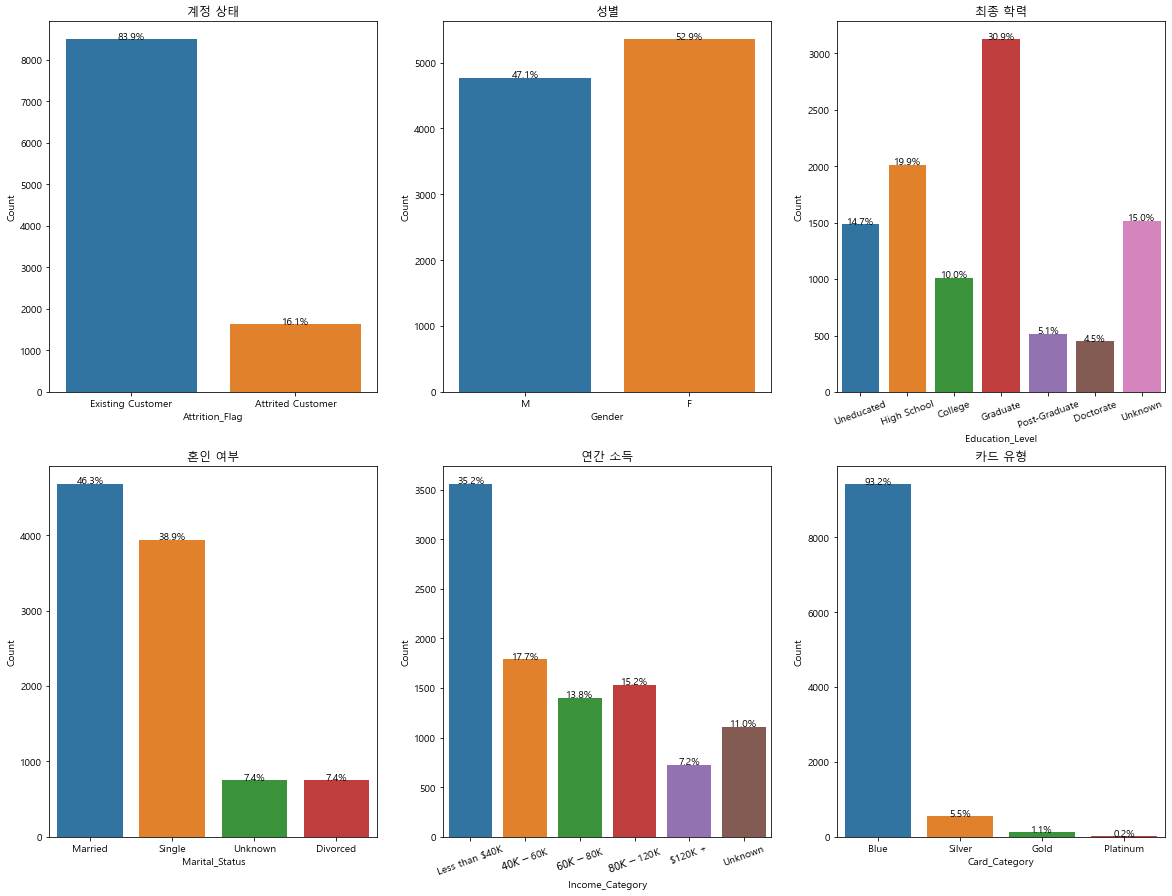

In [7]:
# 각 변수에 알리아스를 지정해서 그래프 그리기
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.countplot(data=df, x='Attrition_Flag', ax=ax1)
sns.countplot(data=df, x='Gender', ax=ax2)
sns.countplot(data=df, x='Education_Level', ax=ax3,
              order=["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate", "Unknown"])
sns.countplot(data=df, x='Marital_Status', ax=ax4)
sns.countplot(data=df, x='Income_Category', ax=ax5, 
              order=["Less than $40K", "$40K - $60K", "$60K - $80K", "$80K - $120K", "$120K +", "Unknown"])
sns.countplot(data=df, x='Card_Category', ax=ax6,
              order=["Blue", "Silver", "Gold", "Platinum"])

# % 표현
total = float(len(df))
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in ax:
    for p in i.patches:
        height = p.get_height()
        i.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(100 * height/total),
                ha="center") 


# 제목 추가
ax1.set(ylabel='Count', title='계정 상태')
ax2.set(ylabel='Count', title='성별')
ax3.set(ylabel='Count', title='최종 학력')
ax4.set(ylabel='Count', title='혼인 여부')
ax5.set(ylabel='Count', title='연간 소득')
ax6.set(ylabel='Count', title='카드 유형')


plt.sca(ax3)
plt.xticks(rotation=20)
plt.sca(ax5)
plt.xticks(rotation=20)

plt.show()

## 2.2. 연속형 데이터 EDA

[Text(0.5, 1.0, '지난 12개월 동안의 연락처 수')]

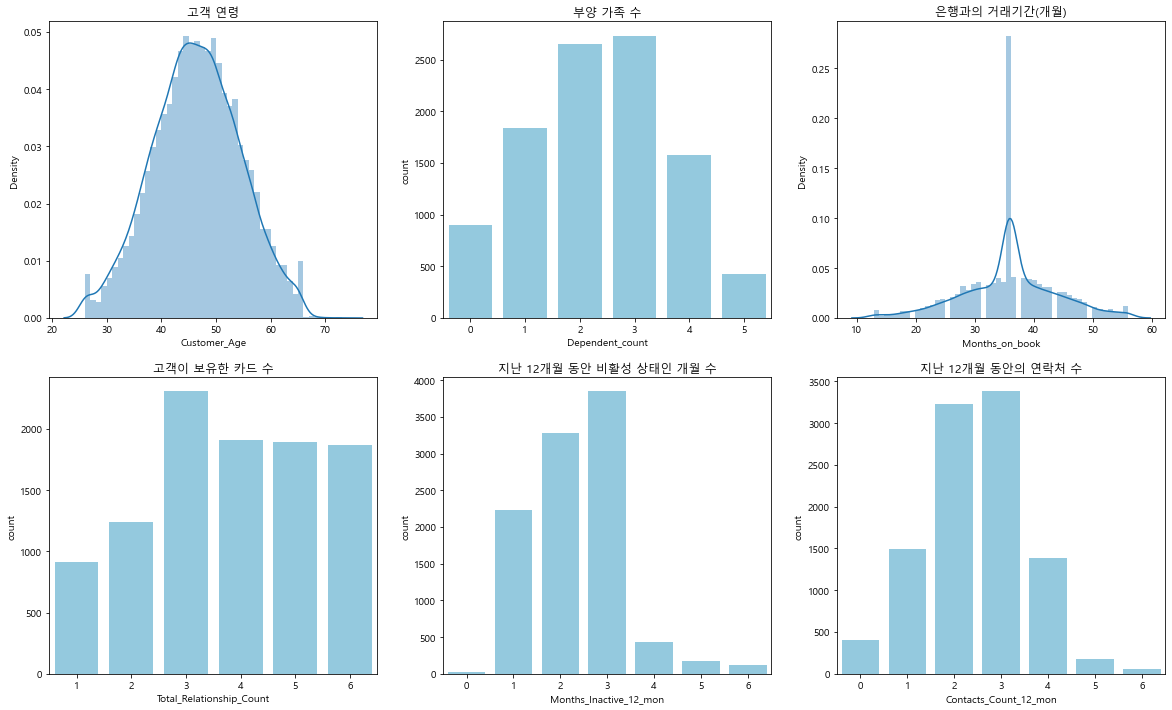

In [8]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,12)

sns.distplot(df['Customer_Age'], ax=ax1)
sns.countplot(data=df, x='Dependent_count', ax=ax2, color="skyblue")
sns.distplot(df['Months_on_book'], ax=ax3)
sns.countplot(data=df, x='Total_Relationship_Count', ax=ax4, color="skyblue")
sns.countplot(data=df, x='Months_Inactive_12_mon', ax=ax5, color="skyblue")
sns.countplot(data=df, x='Contacts_Count_12_mon', ax=ax6, color="skyblue")

ax1.set(title='고객 연령')
ax2.set(title='부양 가족 수')
ax3.set(title='은행과의 거래기간(개월)')
ax4.set(title='고객이 보유한 카드 수')
ax5.set(title='지난 12개월 동안 비활성 상태인 개월 수')
ax6.set(title='지난 12개월 동안의 연락처 수')

<AxesSubplot:xlabel='Months_on_book', ylabel='count'>

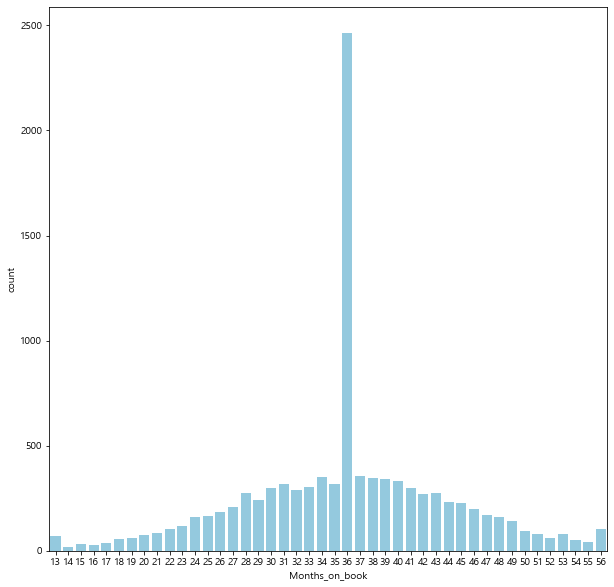

In [23]:
plt.figure(figsize = (10, 10))
sns.countplot(data=df, x='Months_on_book', color="skyblue")

은행과의 거래기간이 36개월인 사람이 압도적으로 많다는 것이 눈에 띈다.

[Text(0.5, 1.0, '지난 12개월 동안의 연락처 수')]

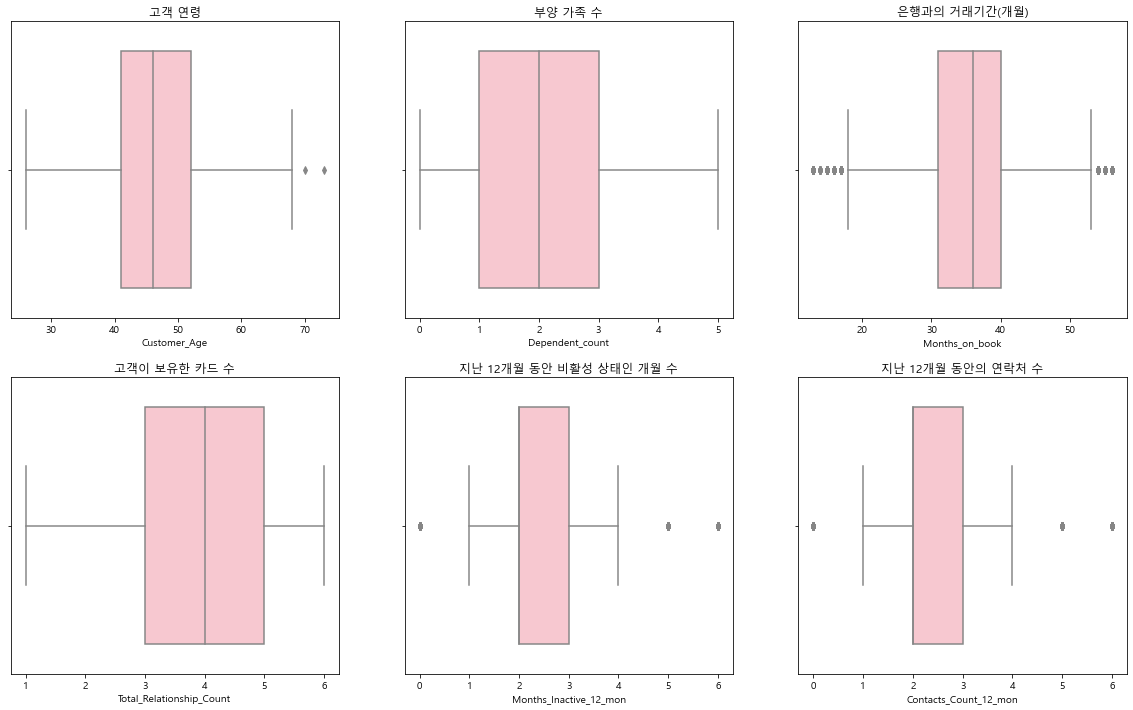

In [232]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,12)

sns.boxplot(data=df, x='Customer_Age', ax=ax1, color="pink")
sns.boxplot(data=df, x='Dependent_count', ax=ax2, color="pink")
sns.boxplot(data=df, x='Months_on_book', ax=ax3, color="pink")
sns.boxplot(data=df, x='Total_Relationship_Count', ax=ax4, color="pink")
sns.boxplot(data=df, x='Months_Inactive_12_mon', ax=ax5, color="pink")
sns.boxplot(data=df, x='Contacts_Count_12_mon', ax=ax6, color="pink")

ax1.set(title='고객 연령')
ax2.set(title='부양 가족 수')
ax3.set(title='은행과의 거래기간(개월)')
ax4.set(title='고객이 보유한 카드 수')
ax5.set(title='지난 12개월 동안 비활성 상태인 개월 수')
ax6.set(title='지난 12개월 동안의 연락처 수')

[Text(0.5, 1.0, '거래 금액의 변동 (Q1 대비 Q4)')]

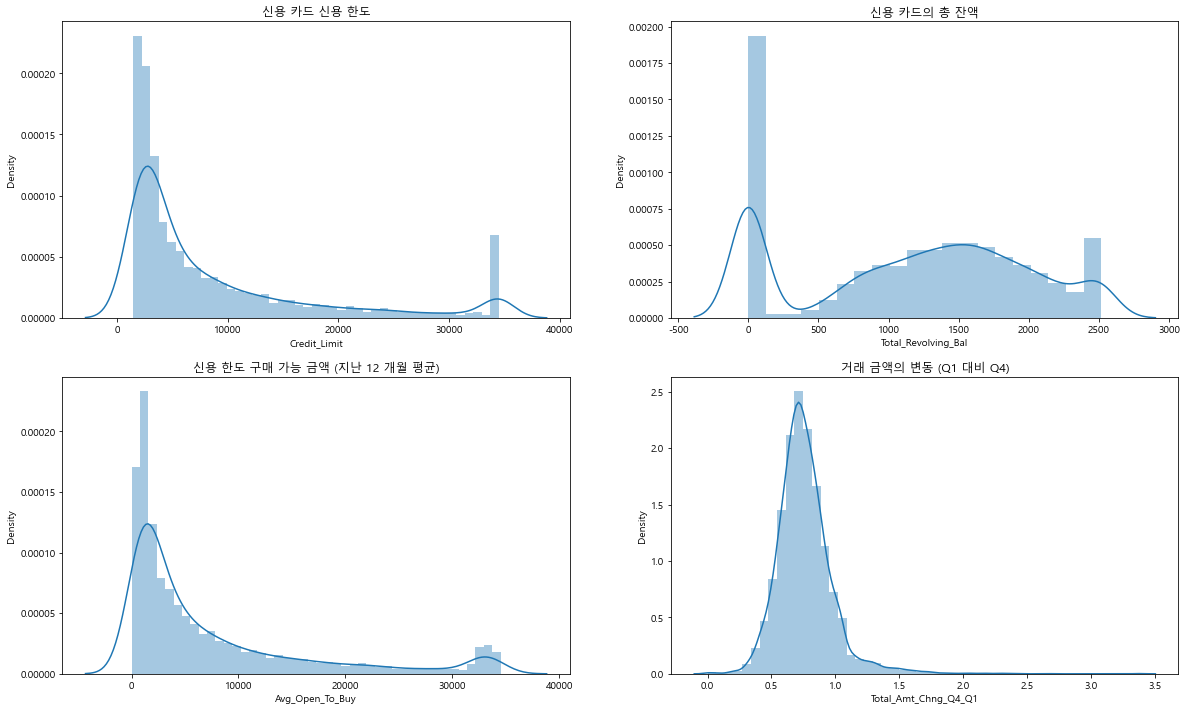

In [172]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.distplot(df['Credit_Limit'], ax=ax1)
sns.distplot(df['Total_Revolving_Bal'], ax=ax2)
sns.distplot(df['Avg_Open_To_Buy'], ax=ax3)
sns.distplot(df['Total_Amt_Chng_Q4_Q1'], ax=ax4)

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')

[Text(0.5, 1.0, '거래 금액의 변동 (Q1 대비 Q4)')]

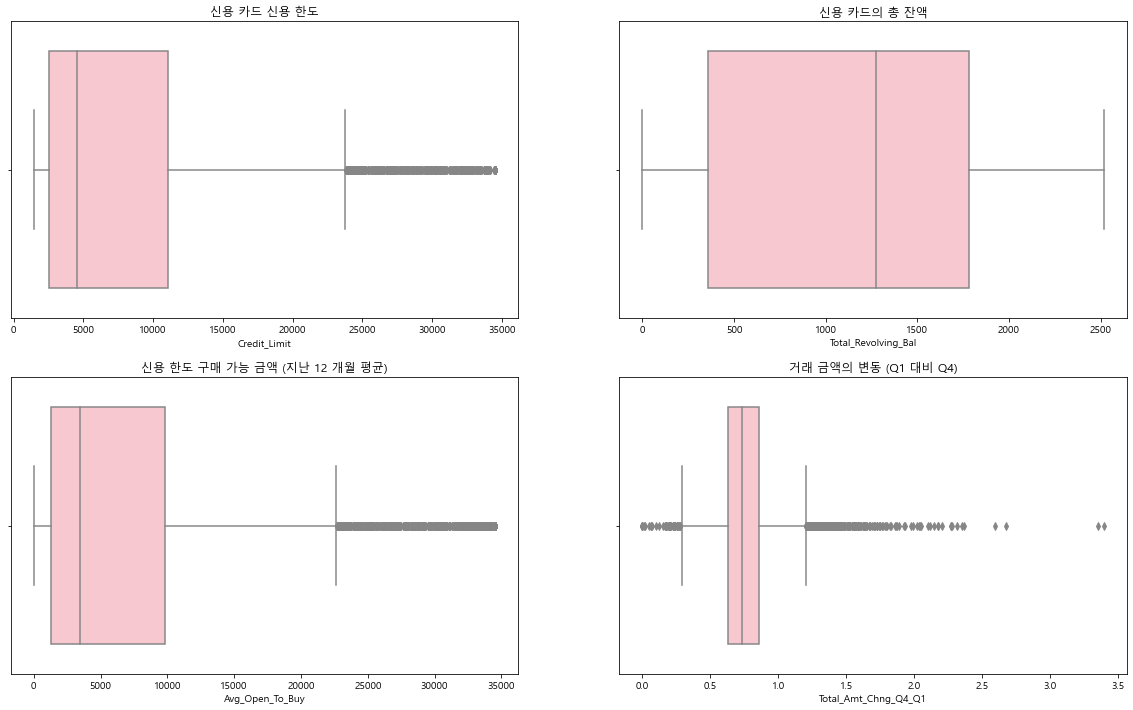

In [173]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.boxplot(data=df, x='Credit_Limit', ax=ax1, color="pink")
sns.boxplot(data=df, x='Total_Revolving_Bal', ax=ax2, color="pink")
sns.boxplot(data=df, x='Avg_Open_To_Buy', ax=ax3, color="pink")
sns.boxplot(data=df, x='Total_Amt_Chng_Q4_Q1', ax=ax4, color="pink")

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')

In [174]:
df[df['Total_Amt_Chng_Q4_Q1'] > 3.0]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
12,710599683,Existing Customer,56,M,1,College,Single,$80K - $120K,Blue,36,...,6,0,11751.0,0,11751.0,3.397,1539,17,3.250,0.000


[Text(0.5, 1.0, '평균 카드 사용률')]

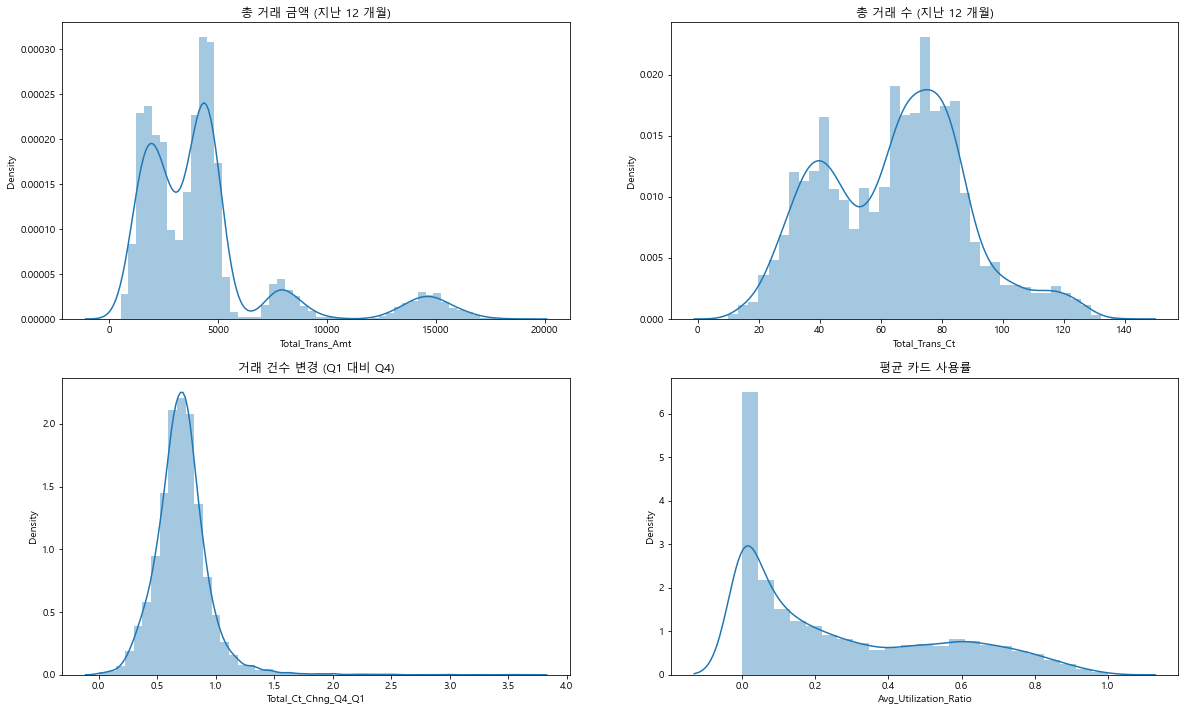

In [175]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.distplot(df['Total_Trans_Amt'], ax=ax1)
sns.distplot(df['Total_Trans_Ct'], ax=ax2)
sns.distplot(df['Total_Ct_Chng_Q4_Q1'], ax=ax3)
sns.distplot(df['Avg_Utilization_Ratio'], ax=ax4)

ax1.set(title='총 거래 금액 (지난 12 개월)')
ax2.set(title='총 거래 수 (지난 12 개월)')
ax3.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax4.set(title='평균 카드 사용률')

[Text(0.5, 1.0, '평균 카드 사용률')]

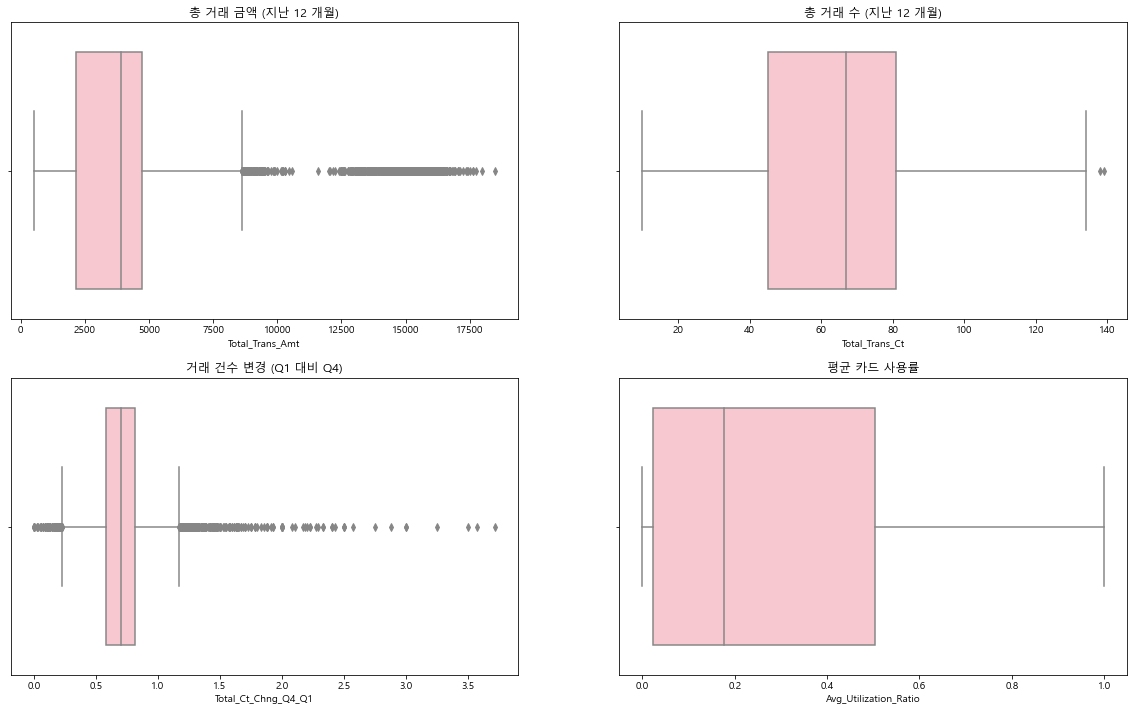

In [176]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.boxplot(data=df, x='Total_Trans_Amt', ax=ax1, color="pink")
sns.boxplot(data=df, x='Total_Trans_Ct', ax=ax2, color="pink")
sns.boxplot(data=df, x='Total_Ct_Chng_Q4_Q1', ax=ax3, color="pink")
sns.boxplot(data=df, x='Avg_Utilization_Ratio', ax=ax4, color="pink")

ax1.set(title='총 거래 금액 (지난 12 개월)')
ax2.set(title='총 거래 수 (지난 12 개월)')
ax3.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax4.set(title='평균 카드 사용률')

- EDA를 통해 각 변수들을 시각화하여 살펴보고 이상치를 확인했다.
- 이상치들이 더러 있었지만, 비정상적으로 극단적인 이상치(ex, 1000회 이상의 거래 횟수)는 발견되지 않았기에 확인된 이상치는 모두 수용하기로 결정했다.

# 3. 원핫 인코딩(One-Hot Encoding)

In [177]:
train = pd.get_dummies(df, columns = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'])
train.head()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


In [178]:
train.columns

Index(['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag_Attrited Customer', 'Attrition_Flag_Existing Customer',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknow

In [179]:
# target 변수인 Attrition_Flag_Attrited Customer와
# 직접적인 target변수는 아니지만 관련이 있는 Attrition_Flag_Existing Customer를 제거하고
# 나머지 변수를 input_var에 담는다.
input_var = ['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'
]

# 4. 다중공선성(multicollinearity) 검사

In [180]:
train.head()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


In [181]:
corr = train[input_var].corr()
corr.style.background_gradient(cmap='coolwarm')

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
Customer_Age,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114,0.017312,-0.017312,-0.014788,0.025199,-0.000203,0.001199,-0.022081,0.005057,0.005377,-0.042614,0.047364,-0.011248,-0.026694,0.044332,-0.013804,-0.017869,0.005381,-0.002573,-0.002264,0.021409,-0.011901,0.006515,-0.019425
Dependent_count,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135,-0.004563,0.004563,0.003369,-0.003368,0.000671,-0.013127,0.009459,0.002190,0.004922,0.006697,0.014385,-0.040707,0.041743,0.024831,-0.013493,0.028975,0.047611,-0.046785,-0.019205,-0.027671,0.027035,0.003555,0.017322
Months_on_book,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541,0.006728,-0.006728,-0.010281,0.024114,0.003531,0.002637,-0.016703,0.001099,-0.003610,-0.027678,0.033194,-0.005065,-0.026145,0.033532,-0.003204,-0.016635,0.007720,-0.004300,-0.007688,0.014934,-0.005426,0.001791,-0.014357
Total_Relationship_Count,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663,-0.003157,0.003157,-0.013582,-0.009077,0.005397,-0.001707,0.012050,0.008202,-0.003969,0.009276,0.017001,-0.017329,-0.009376,-0.006090,-0.008747,0.005475,0.001185,0.005109,0.000490,0.085789,-0.055678,-0.043289,-0.060566
Months_Inactive_12_mon,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503,0.011163,-0.011163,0.004038,0.002432,0.005885,-0.005575,-0.006240,0.010127,-0.012378,0.001796,-0.007065,0.008973,-0.005053,-0.002661,-0.021437,-0.004616,-0.005910,0.018848,0.011446,0.016565,-0.003283,-0.004013,-0.016034
Contacts_Count_12_mon,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471,-0.039987,0.039987,-0.008996,-0.001016,0.002660,-0.003927,-0.006878,0.012596,0.000843,-0.008389,0.001598,0.007997,-0.009562,0.020744,0.002336,0.000167,0.011473,-0.023255,0.002195,0.000929,-0.000685,0.001797,-0.001059
Credit_Limit,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965,-0.420806,0.420806,0.001929,-0.005195,-0.004844,-0.001432,0.005879,0.012213,-0.006478,0.022578,-0.056713,0.032309,0.025291,0.339211,-0.161605,0.093808,0.333828,-0.395233,0.034186,-0.515644,0.234331,0.105976,0.441030
Total_Revolving_Bal,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022,-0.029658,0.029658,-0.011058,-0.018208,-0.000356,0.019276,0.007068,-0.004446,-0.001219,-0.002368,0.039124,-0.037794,-0.001756,0.020264,0.005220,-0.003847,0.022776,-0.015974,-0.020578,-0.022681,0.023974,0.005739,0.012799
Avg_Open_To_Buy,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808,-0.418059,0.418059,0.002920,-0.003562,-0.004811,-0.003160,0.005244,0.012609,-0.006368,0.022786,

서로 높은 상관성(0.5 이상)을 띄는 변수들은 다음과 같다.
- Months_on_book ------  Customer_Age	
- Credit_Limit ------ Avg_Open_To_Buy
- Total_Trans_Amt ------ Total_Trans_Ct
- Avg_Utilization_Ratio ------ Total_Revolving_Bal
- Gender_F ------ Income_Category_Less than $40K

각 쌍 중 하나의 변수만 제거해야한다. 그 기준은 타겟값과의 상관계수.<br>
상관계수의 절대값이 더 작은 것을 제거한다.<br>
타겟값 : Attrition_Flag_Attrited Customer

Months_on_book ------  Customer_Age	

In [182]:
a = train['Months_on_book'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Customer_Age'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

0.013686851177909883
0.018203138532550733


In [183]:
del train['Months_on_book']

Credit_Limit ------ Avg_Open_To_Buy

In [184]:
a = train['Credit_Limit'].corr(train['Attrition_Flag_Attrited Customer'])
b= train['Avg_Open_To_Buy'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

-0.02387299483616173
-0.0002850774939378324


In [185]:
del train['Avg_Open_To_Buy']

Total_Trans_Amt ------ Total_Trans_Ct

In [186]:
a = train['Total_Trans_Amt'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Total_Trans_Ct'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

-0.1685983814100802
-0.3714027011889301


In [187]:
del train['Total_Trans_Amt']

Avg_Utilization_Ratio ------ Total_Revolving_Bal

In [188]:
a = train['Avg_Utilization_Ratio'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Total_Revolving_Bal'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

-0.17841033156174765
-0.26305288312920533


In [189]:
del train['Avg_Utilization_Ratio']

Gender_F ------ Income_Category_Less than $40K

In [190]:
a = train['Gender_F'].corr(train['Attrition_Flag_Attrited Customer'])
b = train['Income_Category_Less than $40K'].corr(train['Attrition_Flag_Attrited Customer'])
print(a)
print(b)

0.037271695731361354
0.02246554580663777


In [191]:
del train['Income_Category_Less than $40K']

In [192]:
# 추가적으로 Gender_F와 Gender_M은 완전히 반대되는 변수이므로 둘 중 하나를 지워준다.
del train['Gender_M']
# Attrition_Flag_Existing Customer도 타겟변수의 반대되는 변수일 분이므로 지운다.
del train['Attrition_Flag_Existing Customer']

In [193]:
train.columns

Index(['CLIENTNUM', 'Customer_Age', 'Dependent_count',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Attrition_Flag_Attrited Customer', 'Gender_F',
       'Education_Level_College', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High School',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_$120K +',
       'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K',
       'Income_Category_$80K - $120K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'],
      dtype='object')

In [194]:
input_var =['Customer_Age', 'Dependent_count',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Gender_F', 'Education_Level_College', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High School',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_$120K +',
       'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K',
       'Income_Category_$80K - $120K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'
]

# 5. 모델링

## 5.1. Random Forest

In [195]:
from sklearn.ensemble import RandomForestClassifier

# 모델 정의
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 10)

In [196]:
# 기존 train 데이터를 랜덤포레스트에서만 사용할 rf_train, rf_test로 분리
# 고유 컬럼인 CLIENTNUM를 이용해 약 8:2 비율로.(총 데이터는 10127개)
rf_train = train.sample(8000, replace = False, random_state = 2021)
rf_test = train.loc[ ~train['CLIENTNUM'].isin(rf_train['CLIENTNUM'])]

In [197]:
# train 학습. 인풋변수와 타겟변수
rf.fit(rf_train[input_var], rf_train['Attrition_Flag_Attrited Customer'])

RandomForestClassifier(min_samples_split=10, n_estimators=500)

In [198]:
# test 데이터 예측
predictions = rf.predict(rf_test[input_var])

In [199]:
rf_test['pred'] = predictions

In [200]:
(rf_test['pred'] == rf_test['Attrition_Flag_Attrited Customer']).mean()

0.9308885754583921

약 93%의 정확도를 보인다.

In [201]:
# 각 변수에 대한 변수중요도 확인하기(input_var의 순서와 같음)
feature_imp = rf.feature_importances_
feature_imp

array([0.04197038, 0.01718695, 0.07332415, 0.03852398, 0.04361499,
       0.05569509, 0.16671143, 0.07639723, 0.23799686, 0.16169719,
       0.01463827, 0.00336989, 0.00344036, 0.00386731, 0.00375165,
       0.00303809, 0.00382484, 0.00393771, 0.002811  , 0.00861299,
       0.00571589, 0.00272588, 0.00303172, 0.00410945, 0.00416744,
       0.00422038, 0.00349707, 0.00290357, 0.00194585, 0.00071112,
       0.00256125])

In [202]:
# 보기 쉽게 데이터프레임으로 만들기
imp_df = pd.DataFrame({'var':input_var,
                       'imp':feature_imp})

# 큰 값부터 순서대로 정렬
imp_df.sort_values(['imp'], ascending=False)

,var,imp
8,Total_Trans_Ct,0.237997
6,Total_Revolving_Bal,0.166711
9,Total_Ct_Chng_Q4_Q1,0.161697
7,Total_Amt_Chng_Q4_Q1,0.076397
2,Total_Relationship_Count,0.073324
5,Credit_Limit,0.055695
4,Contacts_Count_12_mon,0.043615
0,Customer_Age,0.041970
3,Months_Inactive_12_mon,0.038524
1,Dependent_count,0.017187


고객이탈에 가장 영향을 많이 주는 변수는 다음과 같다.
1. Total_Trans_Ct : 총 거래 수 (지난 12 개월)
2. Total_Revolving_Bal : 신용 카드의 총 잔액
3. Total_Ct_Chng_Q4_Q1 : 거래 건수 변경 (Q1 대비 Q4)
4. Total_Amt_Chng_Q4_Q1 : 거래 금액의 변동 (Q1 대비 Q4)

In [203]:
# plt.figure(figsize=(20,20))
# _ = tree.plot_tree(rf.estimators_[0],
#                    feature_names=rf_train.columns,
#                    #fontsize=10,
#                    filled=True)

In [204]:
# rf.estimators_[0].tree_.max_depth

[Text(0.5, 1.0, '거래 금액의 변동 (Q1 대비 Q4)')]

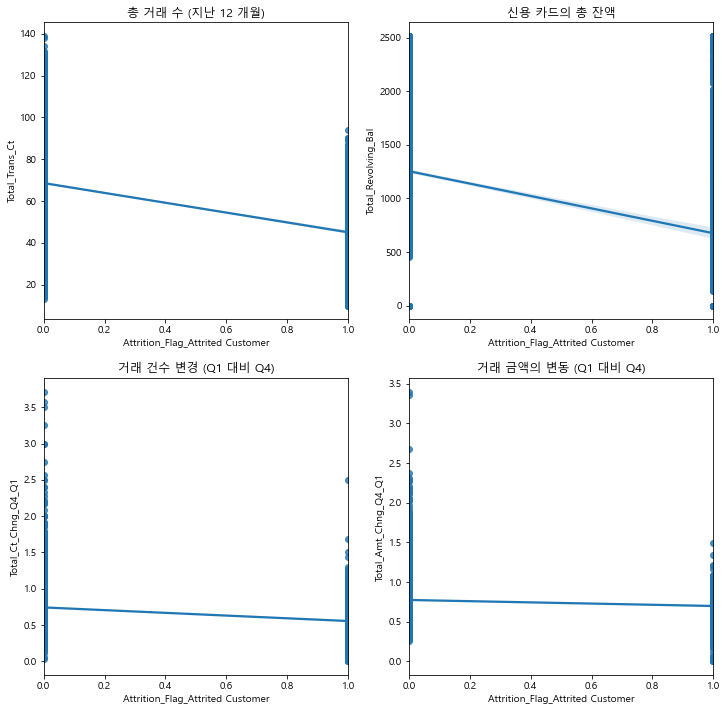

In [205]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12,12)

sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Trans_Ct', ax=ax1)
sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Revolving_Bal', ax=ax2)
sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Ct_Chng_Q4_Q1', ax=ax3)
sns.regplot(data = rf_train, x = 'Attrition_Flag_Attrited Customer', y = 'Total_Amt_Chng_Q4_Q1', ax=ax4)


ax1.set(title='총 거래 수 (지난 12 개월)')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')

1. 지난 12개월동안 총 거래 수가 적을 수록 이탈 가능성이 높다.
2. 신용카드의 총 잔액이 적을 수록 이탈 가능성이 높다.
3. 1분기 대비 4분기 거래 건수가 적을 수록 이탈 가능성이 높다.
4. 1분기 대비 4분기 거래 금액이 적을 수록 이탈 가능성이 높다.

## 5.2. XGBoost

In [206]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [224]:
X = train[input_var]
y = train['Attrition_Flag_Attrited Customer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.shape

(7595, 31)

In [225]:
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1)
xgb.fit(train[input_var], train['Attrition_Flag_Attrited Customer'])

[14:11:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [226]:
y_pred = xgb.predict(X_test)
y_true = y_test

In [227]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse

0.034421419541075714

Attrition_Flag_Attrited Customer 는 0 또는 1의 값을 가지기에 해당 RMSE 결과는 약 3.4%의 오차율이라고 볼 수 있다.

In [212]:
import shap

In [213]:
shap_values = shap.TreeExplainer(xgb).shap_values(train[input_var])

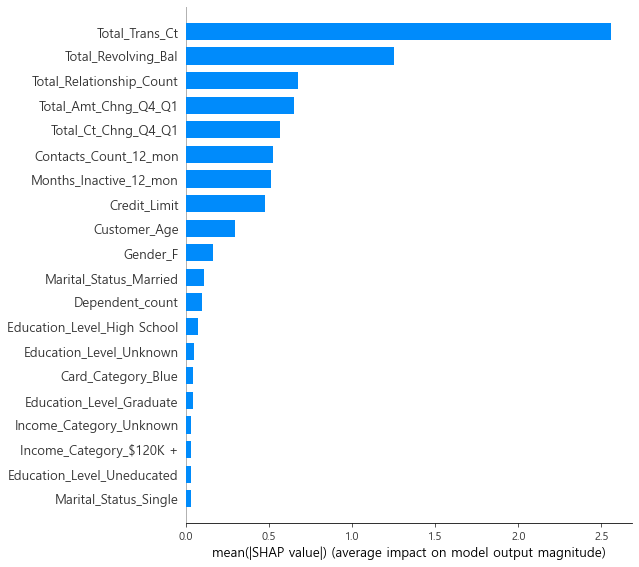

In [214]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

Random Forest에서의 변수중요도와는 다르게 Total_Relationship_Count가 5위에서 3위로 올라왔다.

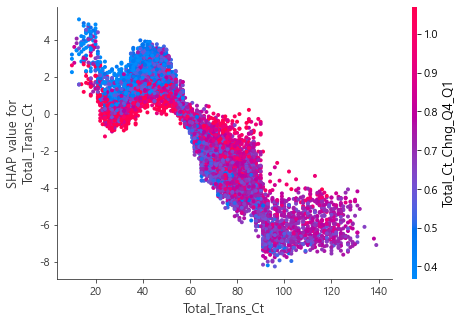

In [219]:
shap.dependence_plot('Total_Trans_Ct', shap_values, train[input_var])

- [지난 12개월의 총 거래수]가 많을수록 이탈 가능성은 낮아진다.
- 약 60회 이상이 되면 이탈 가능성이 안정적으로 계속 낮아진다.
- 90회 이상이 되면 이탈 가능성이 더이상 낮아지지는 않는다.

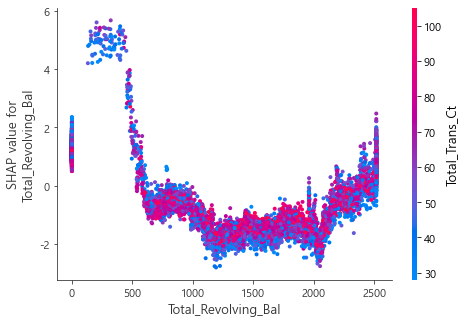

In [216]:
shap.dependence_plot('Total_Revolving_Bal', shap_values, train[input_var])

- [신용 카드의 총 잔액]이 600~2100 달러 일 때 이탈 가능성이 낮다.
- 600달러 미만일 경우 이탈 가능성이 아주 높아진다.

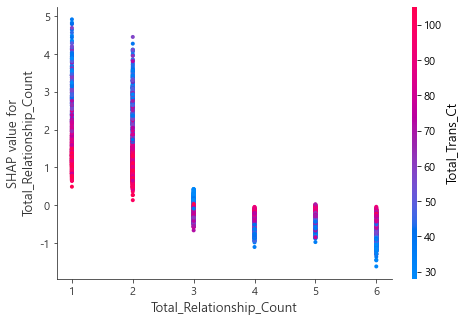

In [230]:
shap.dependence_plot('Total_Relationship_Count', shap_values, train[input_var])

- [고객이 보유한 카드 수]가 3개 미만 일 때는 이탈 가능성이 높고,
- 3개 이상일 때 이탈 가능성이 낮다.
- 카드는 3개지면서 총 거래수가 적을 경우 이탈 가능성이 다소 높아진다.

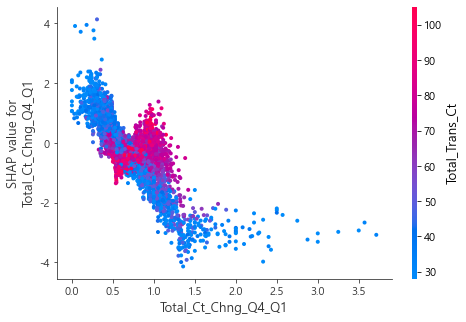

In [228]:
shap.dependence_plot('Total_Ct_Chng_Q4_Q1', shap_values, train[input_var])

- [1분기 대비 4분기 거래 건수]가 50% 이상이면 이탈 가능성이 낮아진다.
- 130% 이상일 경우 안정적으로 이탈 가능성이 낮다.\
- 1분기 대비 4분기의 거래 건수가 거의 변화가 없으면서 총 거래수가 많을 경우 이탈 가능성이 높아진다.

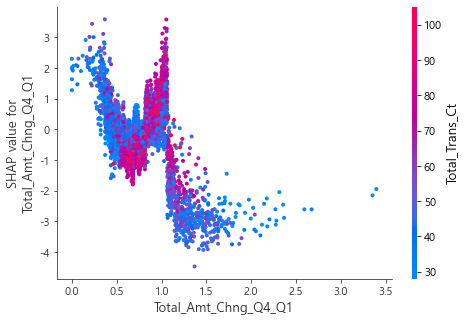

In [229]:
shap.dependence_plot('Total_Amt_Chng_Q4_Q1', shap_values, train[input_var])

- [1분기 대비 4분기 거래 금액]이 50~80%일 때 이탈 가능성이 낮고,
- 110% 이상일 때 안정적으로 이탈 가능성이 낮다.
- 1분기 대비 4분기의 거래 금액이 거의 변화가 없을 때도 이탈 가능성이 높아진다.

# 6. 결론

이탈 가능성이 높은 고객은 다음과 같다.
1. 지난 1년간 총 거래 횟수가 60회 미만
2. 신용카드 잔액이 60달러 미만
3. 보유한 카드 수가 3개 미만
4. 1분기 대비 4분기 거래 횟수가 50% 이하
5. 1분기 대비 4분기 거래 금액이 50% 이하이거나 80~100%

분석 전에 세운 가설인 <br>
'소득이 적을 수록, 카드 등급이 낮을 수록, 카드사용 금액이 적을 수록 이탈 가능성이 높을 것이다'<br>
와는 다르게 소득과 카드 등급은 이탈 가능성에 영향을 주지 못했다.<br>

고객이탈 방지를 위한 대책으로는 다음과 같은 방안들을 고려해볼 수 있다.
1. 총 거래 금액보다는 거래 횟수가 더 중요하기 때문에 소액이라도 자주 카드를 사용할 수 있도록 관련 혜택들을 구상한다.
2. 3개 이상의 카드를 보유한 경우 제공할 혜택들을 구상한다.
3. 연말에 카드를 더 자주 사용할 수 있도록 관련 이벤트를 구상한다.